# ACETONE tutorial #2

**Using other versions of a layer**

Efficiency is a key aspect in the embedded sector, with each code being specifically adpated to a target. As such, we need to be able to choose the implementation of each layer.

In this notebook, we'll explain how to use specific versions of a layer in ACETONE.

* When running this notebook on Colab, we need to install ACETONE 
* If you run this notebook locally, run it in the environment in which you installed ACETONE

The Python code on which the code for manipulating data from the MNIST database was originally written by Mélanie Ducoffe for the ANITI Tech'Session about the librairy DECOMON on 4/04/2025 ([replay](https://www.youtube.com/watch?v=1Jhj3xbsF1k&t=8s)). The code can be found in the [tutorial 3](https://airbus.github.io/decomon/main/tutorials.html) about local robustness to adversarial attacks for classification tasks.

In [1]:
# TODO Installs on collab

In [2]:
# Cleaning the working environment
from pathlib import Path
from os import remove, listdir

def clean_working_directory(directories):
    for directory in directories:
        if directory.exists():
            for file in listdir(directory):
                if not (directory / file).is_dir():
                    remove(directory / file)

# Path to the example files
PATH_DIR = Path("../tests/models/lenet5/lenet5_trained")

# Path to generated directories
loops_output_path = Path("demo_lenet_6loops")
indirect_gemm_output_path = Path("demo_lenet_indirect_gemm")
std_gemm_output_path = Path("demo_lenet_std_gemm")
demo_output_path = Path("demo_lenet_optimized")

files_directories = [loops_output_path, indirect_gemm_output_path, std_gemm_output_path, demo_output_path]

clean_working_directory(files_directories)

## Imports

In this notebook, we'll use as an example a simple Lenet5 model exported to Keras' format h5. The first four activation functions are hyperbolic tangents, while the last one is a softmax.

![lenet5](./data/lenet5_trained.png)

In [3]:
# External imports
import numpy as np
import pystache

import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

# ACETONE's imports
from acetone_nnet import CodeGenerator, cli_compare, list_all_implementations, conv2d_factory
from acetone_nnet.generator import Conv2D

2025-05-13 08:45:55.814637: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 08:45:57.039557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 08:45:57.040419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 08:46:01.435011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## A few useful functions

We define two functions, one to write a set of inputs into an text file and the other to extract the C code's outputs.

In [4]:
def write_input(inputs, nb_tests, file_name):
    """Writes a list of inputs in a text file.

    Args:
        inputs (list[np.ndarray]): The list of inputs to write
        nb_tests (int): The number of inputs
        file_name (str | Path): The path to the file in which the inputs will be written

    Raises:
        ValueError: Can't write more tests (nb_tests) than the number of given inputs
    """
    if nb_tests > len(inputs):
        raise ValueError(f"Can't have more tests to write ({nb_tests}) than values ({len(inputs)})")
    with open(file_name, "w+") as fi:
        for i in range(nb_tests):
            x = inputs[i].flatten()
            out_string = " ".join(
                [f'{float(n).hex().replace("0000000p", "p")}' for n in x],
            )
            print(f"{out_string}", file=fi, flush=True)


def extract_outputs_c(
        path_to_output: str | Path,
        nb_tests: int,
) -> np.ndarray:
    """Get the outputs values from the txt file."""
    output = []
    with Path.open(Path(path_to_output)) as f:
        for i, line in enumerate(f):

            line = line[:-2].split(" ")
            line = list(map(float.fromhex, line))
            line = np.array(line)
            
            output.append(line)
            
            if i >= nb_tests:
                break
    f.close()
    return np.array(output)

## Loading images

We first load MNIST data from keras dataset.

In [5]:
img_rows, img_cols = 28, 28
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255.0
x_test /= 255.0
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)

x_train = np.array([x.reshape((28,28)) for x in x_train])
x_test = np.array([x.reshape((28,28)) for x in x_test])

11490434/11490434 [==============================] - 1s 0us/step


## Generating a test input

We select a few random images to use as support for the later parts of the notebook.

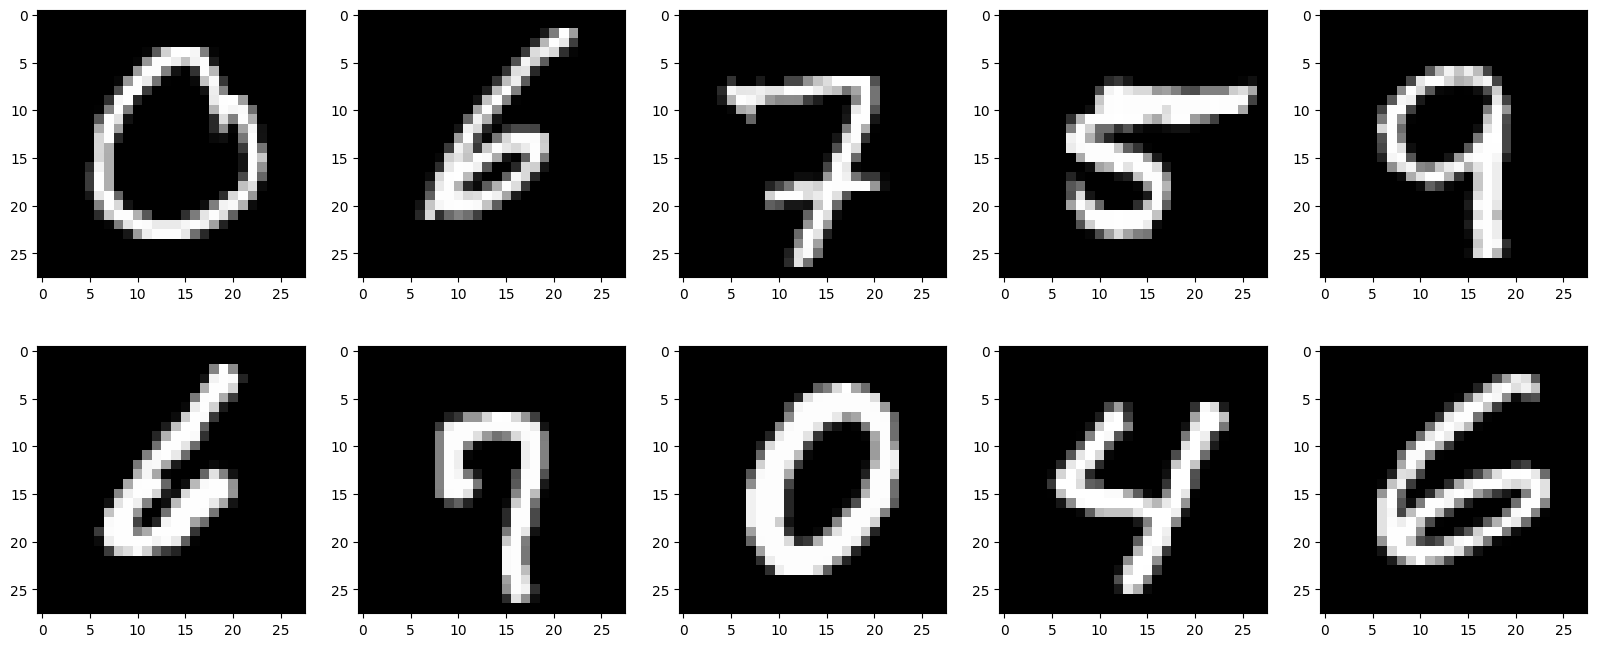

In [29]:
nb_col = 5
nb_row = 2
nb_samples = nb_col*nb_row
indexes = np.random.permutation(len(x_test))[:nb_samples]

inputs = x_test[indexes]

fig,axs = plt.subplots(nb_row,nb_col)

for i in range(nb_row):
    for j in range(nb_col):
        ax = axs[i,j]
        ax.imshow(inputs[i*nb_col+j], cmap="gray")

## Defining common parameters and training the model

We then prepare the CodeGenerator's initialization parameters and train the model.

In [7]:
# Path to the model
model_path = PATH_DIR / "lenet5_trained.h5"
model = keras.models.load_model(model_path)
model.compile("adam", "categorical_crossentropy", metrics=["acc"])

2025-05-13 08:46:15.822322: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
model.fit(x_train, y_train, batch_size=32, shuffle=True, validation_split=0.2, epochs=3)
model.evaluate(x_test, y_test, batch_size=32)

2025-05-13 08:46:16.942660: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


Epoch 1/3
  23/1500 [..............................] - ETA: 6s - loss: 0.0088 - acc: 0.9973

2025-05-13 08:46:19.281059: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23193600 exceeds 10% of free system memory.
2025-05-13 08:46:19.281112: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23193600 exceeds 10% of free system memory.
2025-05-13 08:46:19.282908: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25171200 exceeds 10% of free system memory.
2025-05-13 08:46:19.333809: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23193600 exceeds 10% of free system memory.


1500/1500 [==============================] - 9s 5ms/step - loss: 0.0190 - acc: 0.9936 - val_loss: 0.0267 - val_acc: 0.9909
Epoch 2/3
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0187 - acc: 0.9933 - val_loss: 0.0325 - val_acc: 0.9891
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0514 - acc: 0.9852


[0.05135136842727661, 0.9851999878883362]

The model has an accuracy of `0.98`, which means that out of 100 images, 98 will be well labeled. we will now generate the C code while preserving its semantics.

With our test inputs, we have:

In [32]:
# Inference
keras_outputs = model.predict(inputs)
# The index of the highest scores represents the label
keras_labels = keras_outputs.argmax(axis=-1)

print(f"The labels are: {keras_labels}")

1/1 [==============================] - 0s 25ms/step
The labels are: [0 6 7 5 9 6 7 0 4 6]


In [9]:
# Path to the input file
dataset = Path("./lenet_inputs.txt")
write_input(inputs, nb_samples, dataset)
# Function name
function_name = "demo_lenet"
# Number of tests
nb_tests = nb_samples

## Using ACETONE's native implementations

The framework laready provides, for some layers, several versions from which to choose before generating our code.

In [10]:
implemented = list_all_implementations()
for layer_name in implemented:
    print(layer_name,":")
    for implementation in implemented[layer_name]:
        print("   ", implementation)
    print("\n")

Conv2D :
    6loops
    indirect_gemm_nn
    indirect_gemm_tn
    indirect_gemm_nt
    indirect_gemm_tt
    std_gemm_nn
    std_gemm_tn
    std_gemm_nt
    std_gemm_tt




## Create an ACETONE CodeGenerator from the model

Let's focus on the convolution layer.

The 3 main algorithms provided by ACETONE for the convolution are: *6loops*, *std_gemm* and *indirect_gemm*.

The first algorithm implements the naive version of a convolution: a triple loop iters all the indices of the ouput, and for each of this indices another triple loop compute the value using the input tensor and the kernel, as illustrated below (for a 2D example).

![Conv_6loops](./data/conv_6loops.gif "segment")

(Figure excerpt from [https://www.geeksforgeeks.org/apply-a-2d-convolution-operation-in-pytorch/](https://www.geeksforgeeks.org/apply-a-2d-convolution-operation-in-pytorch/))

We can change the implementation of a specific type of layer by using the class **CodeGenerator**'s argument `versions`.
This argument takes a dictionary containing a reference to the layer (usually the name) as key and the version's name as value.

In [11]:
# Create an ACETONE CodeGenerator from the model
loops_generator = CodeGenerator(
    file=model,
    function_name=function_name,
    external_input=True,
    versions={"Conv2D":"6loops"},
    nb_tests=nb_tests,
    verbose=False,
)

Finished model initialization.


In [12]:
loops_generator.generate_c_files(loops_output_path)

The second algorithm, *std_gemm*, uses the standard gemm (as the name suggests) to compute the convolution. In the generated C code, the convolution is divided in two main parts: the creation of the matrix of patches from the input then the multiplication of the resulting matrix with the kernel matrix.

![Conv_std_gemm](./data/std_gemm.png)

(Figure excerpt from [*Extending a predictable machine learning framework with efficient gemm-based convolution routines*](https://theses.hal.science/ONERA-MIP/hal-04627347v1) written by Iryna De Albuquerque Silva, Thomas Carle, Adrien Gauffriau and Claire Pagetti)

In [13]:
# Create an ACETONE CodeGenerator from the model
std_gemm_generator = CodeGenerator(
    file=model,
    function_name=function_name,
    external_input=True,
    versions={"Conv2D":"std_gemm_nn"},
    nb_tests=nb_tests,
    verbose=False,
)

Finished model initialization.


In [14]:
std_gemm_generator.generate_c_files(std_gemm_output_path)

The third algorithm is another implementation of the gemm algorithm. Instead of computing the patches matrix during the execution of the C code, the framework computes before the generation and adds to the code a matrix of pointers, each referring to the corresponding element in the input tensor. The `im2col` operation is then included in the pointer matrix instead of being computed during execution.

![Conv_indirect_gemm](./data/indirect_gemm.png)

(Figure excerpt from [*Extending a predictable machine learning framework with efficient gemm-based convolution routines*](https://theses.hal.science/ONERA-MIP/hal-04627347v1) written by Iryna De Albuquerque Silva, Thomas Carle, Adrien Gauffriau and Claire Pagetti)

In [15]:
# Create an ACETONE CodeGenerator from the model
indirect_gemm_generator = CodeGenerator(
    file=model,
    function_name=function_name,
    external_input=True,
    versions={"Conv2D":"indirect_gemm_nn"},
    nb_tests=nb_tests,
    verbose=False,
    )

Finished model initialization.


In [16]:
indirect_gemm_generator.generate_c_files(indirect_gemm_output_path)

Conv2D 1 patches size: (14400,)
Conv2D 3 patches size: (9600,)


We can now compile and run those generated code to ensure that the semantic was indeed preserved.

In [17]:
# Compiling the code
! make -C demo_lenet_6loops all

# Running the executable
! ./demo_lenet_6loops/demo_lenet ./demo_lenet_6loops/output_c.txt ./lenet_inputs.txt

make: Entering directory '/tmp_user/ldtim610h/yaitaiss/acetone/tutorials/demo_lenet_6loops'
gcc  -g -w -lm   -c -o inference.o inference.c
gcc  -g -w -lm   -c -o global_vars.o global_vars.c
gcc  -g -w -lm   -c -o main.o main.c
gcc   -o demo_lenet inference.o global_vars.o main.o  inference.h test_dataset.h   -g -w -lm
make: Leaving directory '/tmp_user/ldtim610h/yaitaiss/acetone/tutorials/demo_lenet_6loops'


In [18]:
# Compiling the code
! make -C demo_lenet_std_gemm all

# Running the executable
! ./demo_lenet_std_gemm/demo_lenet ./demo_lenet_std_gemm/output_c.txt ./lenet_inputs.txt

make: Entering directory '/tmp_user/ldtim610h/yaitaiss/acetone/tutorials/demo_lenet_std_gemm'
gcc  -g -w -lm   -c -o inference.o inference.c
gcc  -g -w -lm   -c -o global_vars.o global_vars.c
gcc  -g -w -lm   -c -o main.o main.c
gcc   -o demo_lenet inference.o global_vars.o main.o  inference.h test_dataset.h   -g -w -lm
make: Leaving directory '/tmp_user/ldtim610h/yaitaiss/acetone/tutorials/demo_lenet_std_gemm'


In [19]:
# Compiling the code
! make -C demo_lenet_indirect_gemm all

# Running the executable
! ./demo_lenet_indirect_gemm/demo_lenet ./demo_lenet_indirect_gemm/output_c.txt ./lenet_inputs.txt

make: Entering directory '/tmp_user/ldtim610h/yaitaiss/acetone/tutorials/demo_lenet_indirect_gemm'
gcc  -g -w -lm   -c -o inference.o inference.c
gcc  -g -w -lm   -c -o global_vars.o global_vars.c
gcc  -g -w -lm   -c -o main.o main.c
gcc   -o demo_lenet inference.o global_vars.o main.o  inference.h test_dataset.h   -g -w -lm
make: Leaving directory '/tmp_user/ldtim610h/yaitaiss/acetone/tutorials/demo_lenet_indirect_gemm'


In [20]:
cli_compare(reference_file=(indirect_gemm_output_path / "output_c.txt"), c_file=(std_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)

    Max absolute error for 10 test(s): 0.0
    Max relative error for 10 test(s): 0.0



In [31]:
loops_output = extract_outputs_c(path_to_output=(loops_output_path / "output_c.txt"), nb_tests=nb_tests)
std_gemm_output = extract_outputs_c(path_to_output=(std_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)
indirect_gemm_output = extract_outputs_c(path_to_output=(indirect_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)

loops_labels = loops_output.argmax(axis = -1)
std_gemm_labels = std_gemm_output.argmax(axis = -1)
indirect_gemm_labels = indirect_gemm_output.argmax(axis = -1)


print("Labels given by the inference:")
for i in range(nb_row):
    for j in range(nb_col):
        ax = axs[i,j]
        ax.imshow(inputs[i*nb_col+j], cmap="gray")
        print(f"sample at position ({i},{j}) : ")
        print(f"    keras :         {keras_labels[i*nb_col+j]}")
        print(f"    6loops :        {loops_labels[i*nb_col + j]}")
        print(f"    std_gemm :      {std_gemm_labels[i*nb_col + j]}")
        print(f"    indirect_gemm : {indirect_gemm_labels[i*nb_col + j]}")

Labels given by the inference:
sample at position (0,0) : 
    keras :         0
    6loops :        3
    std_gemm :      3
    indirect_gemm : 3
sample at position (0,1) : 
    keras :         6
    6loops :        4
    std_gemm :      4
    indirect_gemm : 4
sample at position (0,2) : 
    keras :         7
    6loops :        5
    std_gemm :      5
    indirect_gemm : 5
sample at position (0,3) : 
    keras :         5
    6loops :        9
    std_gemm :      9
    indirect_gemm : 9
sample at position (0,4) : 
    keras :         9
    6loops :        8
    std_gemm :      8
    indirect_gemm : 8
sample at position (1,0) : 
    keras :         6
    6loops :        8
    std_gemm :      8
    indirect_gemm : 8
sample at position (1,1) : 
    keras :         7
    6loops :        6
    std_gemm :      6
    indirect_gemm : 6
sample at position (1,2) : 
    keras :         0
    6loops :        8
    std_gemm :      8
    indirect_gemm : 8
sample at position (1,3) : 
    keras :  

The generated code gives indeed the same label for all the implementations.

## Adding a new implementation

Let's now assume that, after studies and tests, we have found a new way to perform a convolution : setting each element of the output to `0.42`.

This method being far more efficient and simple than any other, we want to use it with ACETONE. But, sadly, the framework doesn't have an implementation for it, we have to add it ourselves.

In [22]:
# Printing all the algorithm implemented in ACETONE for a convolution
print("Base implementations : ")
print(conv2d_factory.list_implementations)

Base implementations : 
['6loops', 'indirect_gemm_nn', 'indirect_gemm_tn', 'indirect_gemm_nt', 'indirect_gemm_tt', 'std_gemm_nn', 'std_gemm_tn', 'std_gemm_nt', 'std_gemm_tt']


To implement it, we have to create a new class inheriting from the `Conv2D` class (or one of its child classes).

* The first method we must implement is called `generate_inference_code`. This method will construct the C code correponding to the layer, and return it as a string.
* The second method, `forwad_path_layer`, is optional. It tell the framework how to compute the output of the layer unsing Pyhton. If not given, the method defined in the parent class is used.



In [23]:
# Creating a new implementation
class Conv2D_Demo(Conv2D):

    def __init__(self, **kwargs: int) -> None:
        """Build a Convolution layer with a demo implementation."""
        super().__init__(**kwargs)
    
    def generate_inference_code_layer(self) -> str:
        """Generate computation code for layer."""
        input_str = [prev_layer.output_str for prev_layer in self.previous_layer]
        ouptut_str = f"output_{self.path}"

        code_str =  "    // {{name}}_{{idx}}\n    for (k = 0; k < {{size}}; ++k) {{output_str}}[k] = 0.42;"
        return pystache.render(code_str,{"name":self.name, "idx":self.idx, "size":self.size,"output_str":ouptut_str})
    
    def forward_path_layer(self, input_array) -> np.ndarray:
        return 0.42*np.ones((1,self.output_channels,self.output_height,self.output_width))

When parsing the neural network, each time ACETONE encounters a layer having several versions, it places a temporary layers. Once the model is completely extracted, those placeholders are then replaced by a definitive layer with the correct implementation, simply by extracting the values stored (such as weight, size, biases, ...) and using them to initialize a new layer.

In [24]:
# Creating a Conv2D_Demo layer using the attributes of old_layer
def conv2d_demo_implementation(
        old_layer: Conv2D,
        conv_algo: str,
) -> Conv2D_Demo:
    return Conv2D_Demo(
        idx=old_layer.idx,
        conv_algorithm=conv_algo,
        size=old_layer.size,
        padding=old_layer.padding,
        strides=old_layer.strides,
        kernel_h=old_layer.kernel_h,
        kernel_w=old_layer.kernel_w,
        dilation_rate=old_layer.dilation_rate,
        nb_filters=old_layer.nb_filters,
        input_shape=[1, old_layer.input_channels, old_layer.input_height, old_layer.input_width],
        output_shape=[1, old_layer.output_channels, old_layer.output_height, old_layer.output_width],
        weights=old_layer.weights,
        biases=old_layer.biases,
        activation_function=old_layer.activation_function,
    )

Finally, to add the newly created implementation to ACETONE, we need to register it within the layer's version manager.

In [25]:
conv2d_factory.register_implementation("demo", conv2d_demo_implementation)

print("Updated implementations : ")
print(conv2d_factory.list_implementations)

Updated implementations : 
['6loops', 'indirect_gemm_nn', 'indirect_gemm_tn', 'indirect_gemm_nt', 'indirect_gemm_tt', 'std_gemm_nn', 'std_gemm_tn', 'std_gemm_nt', 'std_gemm_tt', 'demo']


The new version being available in the list of implementations, we can now use it to generate code.

In [26]:
# Create an ACETONE CodeGenerator from the model
demo_generator = CodeGenerator(file=model,
                                    function_name=function_name,
                                    external_input=True,
                                    versions={"Conv2D":"demo"},
                                    nb_tests=nb_tests,
                                    verbose=False)

demo_generator.generate_c_files(demo_output_path)

Finished model initialization.


The code then has the optimized implementation and is ready to be deployed on any target !

# Study Case

Comparing the outputs of a random dataset is great for tests, but not really demonstratif and adapted to a tutorial like this one. 

To illustrate the conservation of semantics between the different versions seen, we'll use the MNIST dataset.

# Playing a bit more

Let's now try with several set of inputs from the MNIST dataset.

1/1 [==============================] - 0s 15ms/step
Difference between loops implementation and standard gemm implementation:
    Max absolute error for 10 test(s): 0.0
    Max relative error for 10 test(s): 0.0

Difference between indirect gemm implementation and standard gemm implementation:
    Max absolute error for 10 test(s): 0.0
    Max relative error for 10 test(s): 0.0

Comparing Keras and ACETONE's results :
Maximal absolute error between them :  2.384185791015625e-07
Maximal relative error between them :  3.920215288423102e-06


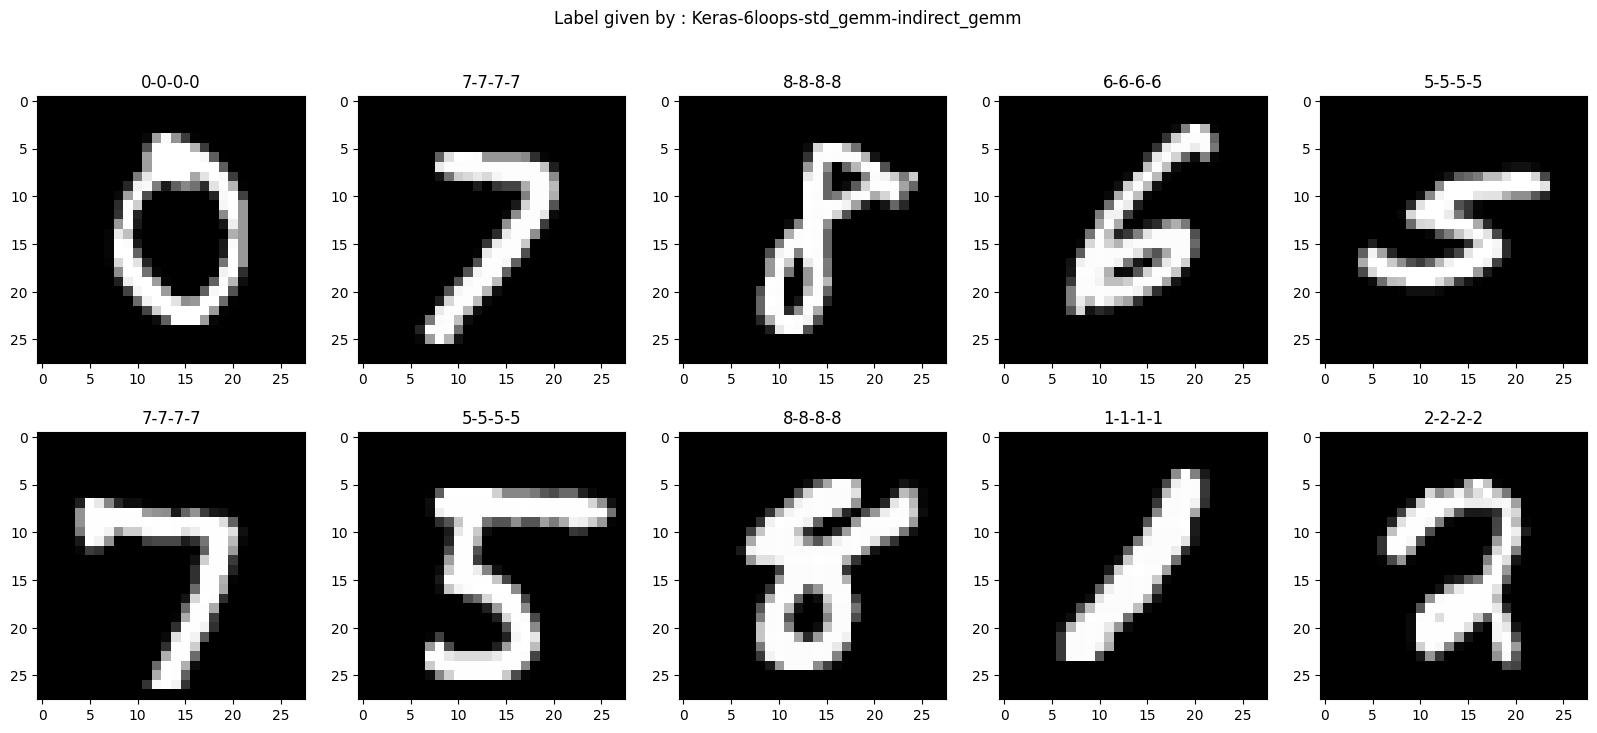

In [35]:
# Selecting new inputs
indexes = np.random.permutation(len(x_test))[:nb_samples]
inputs = x_test[indexes]
write_input(inputs, nb_samples, dataset)

# Keras inference and labels
keras_outputs = model.predict(inputs)
keras_labels = keras_outputs.argmax(axis=-1)

# ACETONE's inference with the 3 versions
! ./demo_lenet_6loops/demo_lenet ./demo_lenet_6loops/output_c.txt ./lenet_inputs.txt
! ./demo_lenet_std_gemm/demo_lenet ./demo_lenet_std_gemm/output_c.txt ./lenet_inputs.txt
! ./demo_lenet_indirect_gemm/demo_lenet ./demo_lenet_indirect_gemm/output_c.txt ./lenet_inputs.txt

# Extracting the scores
loops_output = extract_outputs_c(path_to_output=(loops_output_path / "output_c.txt"), nb_tests=nb_tests)
std_gemm_output = extract_outputs_c(path_to_output=(std_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)
indirect_gemm_output = extract_outputs_c(path_to_output=(indirect_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)

# Getting the labels
loops_labels = loops_output.argmax(axis = -1)
std_gemm_labels = std_gemm_output.argmax(axis = -1)
indirect_gemm_labels = indirect_gemm_output.argmax(axis = -1)

# Comparing the results
max_rel_error = 0.0
max_abs_error = 0.0
for i in range(nb_samples):
    for k in range(10):
        diff = abs(keras_outputs[i,k] - loops_output[i,k])
        norm = abs(keras_outputs[i,k]) + abs(loops_output[i,k])
        max_abs_error = max(max_abs_error , diff)
        if norm != 0:
            max_rel_error = max(max_rel_error, diff/(norm/2))

print("Difference between loops implementation and standard gemm implementation:")
cli_compare(reference_file=(loops_output_path / "output_c.txt"), c_file=(std_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)
print("Difference between indirect gemm implementation and standard gemm implementation:")
cli_compare(reference_file=(indirect_gemm_output_path / "output_c.txt"), c_file=(std_gemm_output_path / "output_c.txt"), nb_tests=nb_tests)

print("Comparing Keras and ACETONE's results :")
print("Maximal absolute error between them : ",max_abs_error)
print("Maximal relative error between them : ",max_rel_error)

fig,axs = plt.subplots(nb_row,nb_col)
fig.suptitle("Label given by : Keras-6loops-std_gemm-indirect_gemm")
for i in range(nb_row):
    for j in range(nb_col):
        ax = axs[i,j]
        ax.imshow(inputs[i*nb_col+j], cmap="gray")
        ax.set_title(f"{keras_labels[i*nb_col+j]}-{loops_labels[i*nb_col+j]}-{std_gemm_labels[i*nb_col+j]}-{indirect_gemm_labels[i*nb_col+j]}")



All four labels are the same, the semantic is preserved !!